<a href="https://colab.research.google.com/github/hakimozcan/Machine-Learning/blob/main/clustering_survey_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Survey Data to Create Personas
## Recommender System Prototype

# Import Packages

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
survey_response = pd.read_csv("/content/drive/MyDrive/UU_ADS/INFOMPPM/survey_responses.csv")
survey_response.shape

(93, 16)

In [ ]:
# Create a copy of the DataFrame
df = survey_response.copy()

# Rename columns for readability
df = df.rename(columns = {'Please provide your age range:': 'age',
                          'Please indicate your gender:': 'gender',
                          'What is your occupation (e.g., student, employed etc.)? ': 'occupation',
                          'How important is content diversity (e.g., different genres, themes, formats etc. ) in your viewing recommendations?': 'content_diversity',
                          'How important is people diversity (e.g., representation of different cultures, races, genders, sexualities etc.) in your viewing recommendations?': 'people_diversity',
                          'How important is it for you to have personalized content recommendations?': 'personalization',
                          'How important is it for you to control the kinds of content recommendations you get?': 'autonomy',
                          'Please rank the following in terms of how important they are to you when it comes to receiving content recommendations: [Recommendations that are tailored to your interests]': 'personalization_rank',
                          'Please rank the following in terms of how important they are to you when it comes to receiving content recommendations: [Recommendations that show you new and varied options]': 'diversity_rank',
                          'Please rank the following in terms of how important they are to you when it comes to receiving content recommendations: [Being able to control the types of recommendations you receive]': 'autonomy_rank',
                          'How often do you watch history-related content?': 'hist_freq',
                          'What kinds of history content are you most interested in? (Select all that apply)': 'history_category',
                          'What is your primary motivation in watching history content?': 'history_motivation',
                          'How satisfied are you with the current recommendations for history content?': 'satisfaction_level',
                          'What are the biggest challenges or frustrations you face when receiving recommendations for history content on streaming platforms?': 'comment'
                          })



# Drop the columns that might not be very necessary for clustering
df = df.drop(['Timestamp', 'comment', 'history_motivation'], axis=1)

# Drop the row that contains "Under 18"
df = df.drop(df[df['age'] == 'Under 18'].index)


# Replace different variations (spelling) of the student with string "Student".
df['occupation'] = df['occupation'].replace(['Student ', 'Stident', 'student', 'student ', 'masters student', 'Student; part time employed', 'Employed (1fte) & student', 'Master student'], 'Student')

# Put different professions into the same category of "Employed".
df['occupation'] = df['occupation'].replace(['Treasury Analyst','Architect','engineer ','Asistant store manager','Psychological Counselor','Manager','Accountant','Medical Doctor','Researcher',
                                             'vr developer', 'White collar', 'Model', 'Attorney', 'employer', 'Employee', 'Employed', 'Employed ', 'employed'], 'Employed')

# Replace different variations (spelling) of the unemployed with string "Unemployed".
df['occupation'] = df['occupation'].replace(['Unemployed', 'unemployed'], 'Unemployed')


df.head()

,age,gender,occupation,content_diversity,people_diversity,personalization,autonomy,personalization_rank,diversity_rank,autonomy_rank,hist_freq,history_category,satisfaction_level
0,25-34,Male,Student,Very important,Somewhat unimportant,Very important,Very important,1st Choice,2nd Choice,3rd Choice,Often,Ancient history,Very satisfied
1,18-24,Female,Student,Very important,Somewhat important,Somewhat important,Somewhat important,1st Choice,3rd Choice,2nd Choice,Sometimes,Social and cultural history;Science and techno...,Somewhat dissatisfied
2,35-44,Male,Employed,Very unimportant,Very unimportant,Very unimportant,Very unimportant,2nd Choice,1st Choice,3rd Choice,Often,Modern history;Art history;World history,Neutral
3,25-34,Male,Employed,Very important,Very important,Somewhat important,Somewhat important,3rd Choice,2nd Choice,1st Choice,Always,Ancient history,Somewhat satisfied
4,45-54,Male,Employed,Somewhat important,Somewhat important,Very important,Very important,1st Choice,2nd Choice,3rd Choice,Often,Social and cultural history;Science and techno...,Somewhat satisfied


In [ ]:
df['occupation'].unique()

array(['Student', 'Employed', 'Unemployed'], dtype=object)

In [ ]:
df.shape

(92, 12)

## Converting categorical columns into numerical format

In [ ]:
df_num = df.copy()
# df_num.drop(['hist_freq', 'satisfaction_level'], axis=1, inplace=True)

In [ ]:
## Define a list of the columns to encode
cols_to_encode = ['age', 'gender', 'occupation', 'content_diversity', 'people_diversity', 'personalization', 'autonomy', 'hist_freq', 'satisfaction_level']

# Use pandas.get_dummies() to perform one-hot encoding on the columns to encode
one_hot = pd.get_dummies(df_num[cols_to_encode])

# Concatenate the one-hot encoded columns with the original data frame
df_num = pd.concat([df_num, one_hot], axis=1)

# Drop the original columns
df_num.drop(cols_to_encode, axis=1, inplace=True)



# Convert ranking preferences into numerical format:
ranking_mapping = {"1st Choice": 1, "2nd Choice": 2, "3rd Choice": 3}

for col in ['personalization_rank', 'diversity_rank', 'autonomy_rank']:
    df_num[col] = df_num[col].map(ranking_mapping)

df_num.head()

In [ ]:
df_num.shape

(92, 43)

# Clustering

## Silhouette Score

In [ ]:
# Define a list of the columns to use for clustering
cols_to_cluster = list(df_num.columns)

# Create a KMeans clustering object with the desired number of clusters
num_of_clusters = 2
max_clusters = 10

# Silhouette Score
def find_optimal_clusters_silhouette(data, min_clusters, max_clusters):
    silhouette_scores = []
    for n_clusters in range(min_clusters, max_clusters+1):
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    best_n_clusters = silhouette_scores.index(max(silhouette_scores)) + min_clusters
    return best_n_clusters, max(silhouette_scores)

min_clusters = 2
best_n_clusters, best_silhouette_score = find_optimal_clusters_silhouette(df_num[cols_to_cluster], min_clusters, max_clusters)
print(f"The optimal number of clusters is {best_n_clusters} with a silhouette score of {best_silhouette_score:.3f}")

The optimal number of clusters is 2 with a silhouette score of 0.281


## Elbow Method

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

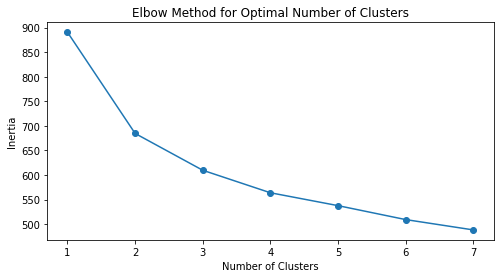

In [ ]:
# Elbow Method
def find_optimal_clusters_elbow(data, max_clusters):
    inertia_values = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_clusters + 1), inertia_values, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

find_optimal_clusters_elbow(df_num[cols_to_cluster], max_clusters)

## K-Means Clustering

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


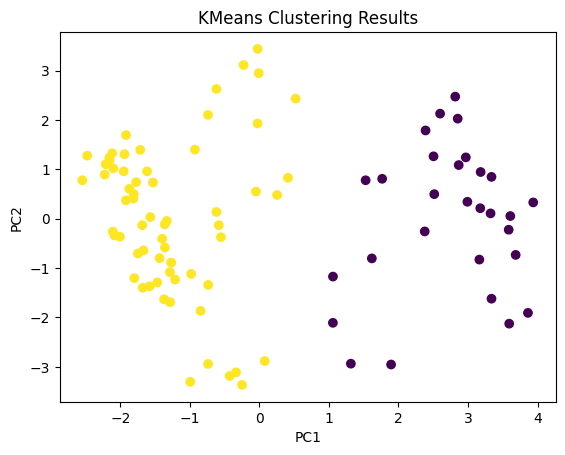

In [ ]:
# KMeans Clustering
kmeans = KMeans(n_clusters=best_n_clusters)
clusters = kmeans.fit_predict(df_num[cols_to_cluster])
df_num['cluster'] = clusters

# PCA for visualization
n_components = 2
pca = PCA(n_components=n_components)
pca_cols = pca.fit_transform(df_num[cols_to_cluster])
df_num['pca1'] = pca_cols[:,0]
df_num['pca2'] = pca_cols[:,1]

# Plot the clusters using the first two principal components as the x and y axes
plt.scatter(df_num['pca1'], df_num['pca2'], c=df_num['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering Results')
plt.show()

# Personas

After successfully identifying the clusters, the next step is to incorporate them into the original data frame and create a duplicate for further analysis. To facilitate understanding of each persona's characteristics, we convert the categorical values in this data frame into numerical formats. This transformation enables us to quantitatively uncover the overall characteristics of each persona, and gain a better understanding into their behavior and preferences.

In [ ]:
df_clus = df.copy()
df_clus['cluster'] = clusters
df_clus.head()

,age,gender,occupation,content_diversity,people_diversity,personalization,autonomy,personalization_rank,diversity_rank,autonomy_rank,hist_freq,satisfaction_level,cluster
0,25-34,Male,Student,Very important,Somewhat unimportant,Very important,Very important,1st Choice,2nd Choice,3rd Choice,Often,Very satisfied,0
1,18-24,Female,Student,Very important,Somewhat important,Somewhat important,Somewhat important,1st Choice,3rd Choice,2nd Choice,Sometimes,Somewhat dissatisfied,0
2,35-44,Male,Employed,Very unimportant,Very unimportant,Very unimportant,Very unimportant,2nd Choice,1st Choice,3rd Choice,Often,Neutral,0
3,25-34,Male,Employed,Very important,Very important,Somewhat important,Somewhat important,3rd Choice,2nd Choice,1st Choice,Always,Somewhat satisfied,1
4,45-54,Male,Employed,Somewhat important,Somewhat important,Very important,Very important,1st Choice,2nd Choice,3rd Choice,Often,Somewhat satisfied,0


In [ ]:
# Define a dictionary of age range and their midpoint values
age_ranges = {
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55-64': 5,
    '65 and above': 6
}

# Replace the age range with their midpoint values
df_clus['age'] = df_clus['age'].map(age_ranges)



# Map the categorical variable 'gender' to numerical values (0 or 1)
df_clus['gender'] = df_clus['gender'].map({'Male': 1, 'Female': 2})



# Convert value preferences into numerical format:

# content diversity, people diversity, personalization and autonomy preferences
ranking_mapping = {"Very important": 1, "Somewhat important": 2, "Neutral": 3, "Somewhat unimportant": 4, "Very unimportant": 5}
for col in ["content_diversity", "people_diversity", "personalization", "autonomy"]:
    df_clus[col] = df_clus[col].map(ranking_mapping)



# Convert value preferences into numerical format:
# Ranking preferences
ranking_mapping = {"1st Choice": 1, "2nd Choice": 2, "3rd Choice": 3}

for col in ["personalization_rank", "diversity_rank", "autonomy_rank"]:
    df_clus[col] = df_clus[col].map(ranking_mapping)



# Convert history frequencies into numerical format:
ranking_mapping = {"Always": 1, "Often": 2, "Sometimes": 3, "Rarely": 4, "Never": 5}
df_clus['hist_freq'] = df_clus['hist_freq'].map(ranking_mapping)



# Convert history frequencies into numerical format:
ranking_mapping = {"Very satisfied": 1, "Somewhat satisfied": 2, "Neutral": 3, "Somewhat dissatisfied": 4, "Very dissatisfied": 5}
df_clus['satisfaction_level'] = df_clus['satisfaction_level'].map(ranking_mapping)



# Convert occupation column into numerical format:
ranking_mapping = {"Student": 1, "Employed": 2, "Unemployed": 3}
df_clus['occupation'] = df_clus['occupation'].map(ranking_mapping)

In [ ]:
df_clus.head()

,age,gender,occupation,content_diversity,people_diversity,personalization,autonomy,personalization_rank,diversity_rank,autonomy_rank,hist_freq,satisfaction_level,cluster
0,2,1.0,1,1,4,1,1,1,2,3,2,1.0,0
1,1,2.0,1,1,2,2,2,1,3,2,3,4.0,0
2,3,1.0,2,5,5,5,5,2,1,3,2,3.0,0
3,2,1.0,2,1,1,2,2,3,2,1,1,2.0,1
4,4,1.0,2,2,2,1,1,1,2,3,2,2.0,0


In [ ]:
# Create separate DataFrames for each cluster
df_clus_1 = df_clus[df_clus['cluster'] == 0]
df_clus_2 = df_clus[df_clus['cluster'] == 1]
# df_clus_3 = df_clus[df_clus['cluster'] == 2]

In [ ]:
print("Cluster0:", df_clus_1.shape, "Cluster1:", df_clus_2.shape)

Cluster0: (63, 13) Cluster1: (29, 13)


In [ ]:
# calculate the mean of each column in the three data frames
mean_df = pd.concat([df_clus_1.mean(), df_clus_2.mean()], axis=1)
mean_df.columns = ['df_clus_1', 'df_clus_2']

# print the result
print(mean_df)

                      df_clus_1  df_clus_2
age                    1.555556   1.793103
gender                 1.555556   1.321429
occupation             1.396825   1.517241
content_diversity      2.031746   2.172414
people_diversity       2.571429   2.896552
personalization        2.015873   2.448276
autonomy               2.333333   1.655172
personalization_rank   1.174603   2.413793
diversity_rank         1.984127   2.344828
autonomy_rank          2.841270   1.241379
hist_freq              3.126984   2.965517
satisfaction_level     2.694915   2.827586
cluster                0.000000   1.000000
